# Feature 

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
import requests as rq
import json
import numpy as np
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup

Read file

In [12]:
train = pd.read_pickle('C:/Users/88690/Desktop/人工/NYCU-Intro-AI-Final-Project/final-project/nytimes-dataset/train_v2.pkl')
train = train.drop(train[train['n_comment'] <= 0].index)
#print(train.columns)
#train = train.drop(columns = ['web_url', 'headline'])
train


,web_url,print_section,print_page,news_desk,section_name,type_of_material,word_count,subsection_name,pub_year,pub_month,...,abstract_len,abstract_dup,headline,headline_len,headline_dup,headline_kicker,len_lead,keywords,authors,n_comment
1,https://www.nytimes.com/2020/12/31/crosswords/...,NaN,NaN,Games,Crosswords & Games,News,670,NaN,2021,1,...,18,0,Party Hearty,2,0,"Wordplay, The CROSSWORD COLUMN",74,[Crossword Puzzles],[Caitlin Lovinger],124
3,https://www.nytimes.com/2021/01/01/nyregion/ny...,A,5,Metro,New York,News,1541,NaN,2021,1,...,29,0,Virus Numbers Are Surging. Why Is New York’s V...,11,0,None,58,"[Coronavirus (2019-nCoV), Vaccination and Immu...",[Joseph Goldstein],250
7,https://www.nytimes.com/2021/01/01/well/family...,NaN,NaN,Well,Well,News,1044,Family,2021,1,...,33,0,Teaching My Child to Love a Dying World,8,0,Ties,85,"[Trees and Shrubs, Children and Childhood, Par...",[Shoshana Meira Friedman],65
9,https://www.nytimes.com/2021/01/01/well/live/n...,D,6,Well,Well,News,1322,Live,2021,1,...,19,0,"For a Healthier 2021, Keep the Best Habits of ...",13,0,Well Challenge Day 1,23,"[Content Type: Service, Habits and Routines (B...",[Tara Parker-Pope],141
10,https://www.nytimes.com/2021/01/01/climate/tru...,A,19,Climate,Climate,News,1582,NaN,2021,1,...,25,0,"How Trump Tried, but Largely Failed, to Derail...",12,0,None,49,"[Global Warming, Environment, Research, United...",[Christopher Flavelle],10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39617,https://www.nytimes.com/interactive/2022/12/31...,NaN,NaN,The Upshot,The Upshot,Interactive Feature,0,NaN,2022,12,...,17,0,Readers Sent Us Pandemic Photos in 2020. Here’...,13,0,None,17,"[Coronavirus (2019-nCoV), Photography, Quarant...","[Alicia Parlapiano, Emily Badger, Claire Mille...",99
39624,https://www.nytimes.com/2022/12/31/books/molly...,NaN,NaN,BookReview,Books,News,819,NaN,2022,12,...,7,17,"The Jackal, the Fox and Auld Lang Syne",8,0,None,2,"[Books and Literature, internal-sub-only-nl]",[Molly Young],18
39634,https://www.nytimes.com/2022/12/31/us/politics...,NaN,NaN,Investigative,U.S.,News,7958,Politics,2022,12,...,22,0,The Invention of Elise Stefanik,5,0,None,5,"[Stefanik, Elise, Trump, Donald J, Republican ...",[Nicholas Confessore],814
39635,https://www.nytimes.com/2022/12/31/world/asia/...,NaN,NaN,Foreign,World,News,3523,Asia Pacific,2022,12,...,33,0,Russia’s War Could Make It India’s World,7,0,None,47,"[vis-photo, International Relations, Politics ...","[Roger Cohen, Mauricio Lima]",325


select bound of is_popular

In [13]:
median = train['n_comment'].median()
print(median)
train['is_popular'] = train['n_comment'].apply(lambda x : 1 if x > median else 0)
pop_count = 0
for i in train['is_popular']:
    if i:
        pop_count += 1
print('popular:    ' , pop_count / len(train))
print('not popular:' , 1 - pop_count / len(train))
#train = train.drop(columns = ['n_comment'])

57.0
popular:     0.49615151777220445
not popular: 0.5038484822277955


In [14]:
print(train.columns)

Index(['web_url', 'print_section', 'print_page', 'news_desk', 'section_name',
       'type_of_material', 'word_count', 'subsection_name', 'pub_year',
       'pub_month', 'pub_day', 'pub_weekday', 'pub_time', 'abstract',
       'abstract_len', 'abstract_dup', 'headline', 'headline_len',
       'headline_dup', 'headline_kicker', 'len_lead', 'keywords', 'authors',
       'n_comment', 'is_popular'],
      dtype='object')


Hour


pub_time
0     0.694969
1     0.579310
2     0.711934
3     0.664474
4     0.272727
5     0.315789
6     0.235669
7     0.519031
8     0.486647
9     0.529435
10    0.563031
11    0.275000
12    0.400862
13    0.309129
14    0.365492
15    0.510516
16    0.461268
17    0.415350
18    0.408854
19    0.500000
20    0.482353
21    0.452471
22    0.539936
23    0.691441
Name: is_popular, dtype: float64
0.13133279029758524


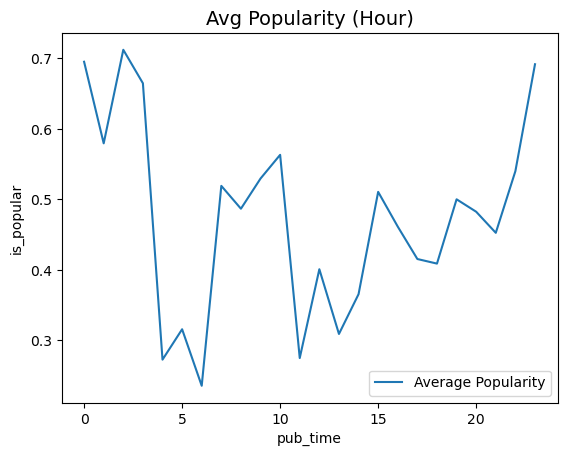

In [15]:
print(train.groupby('pub_time').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_time').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Hour)', fontsize=14)
#plt.axvline(x = 3, linestyle= '--')

train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
print(train.corr()['is_popular']['is_noon'])

Weekday

In [16]:
print(train.groupby('pub_weekday').mean()['is_popular'])

pub_weekday
0    0.486024
1    0.512160
2    0.470563
3    0.461471
4    0.480281
5    0.705298
6    0.533235
Name: is_popular, dtype: float64


0.08345284520516726


Text(0.5, 1.0, 'Avg Popularity (Day of Week)')

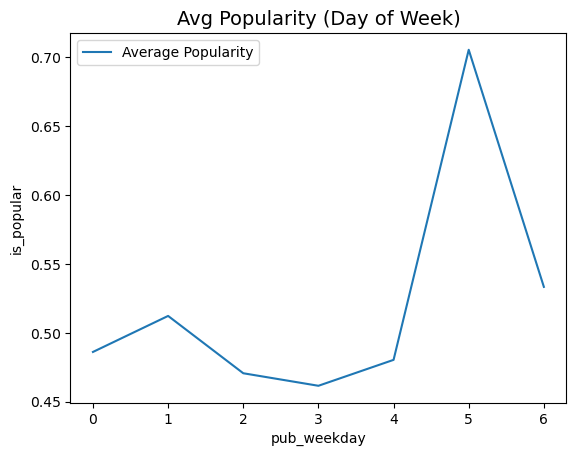

In [17]:
train['is_weekend'] = train['pub_weekday'].apply(lambda x : 1 if (x == 5 or x == 6) else 0)
print(train.corr()['is_popular']['is_weekend'])
sns.lineplot(data = train.groupby('pub_weekday').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Day of Week)', fontsize=14)


pub_day
1     0.488778
2     0.543956
3     0.503876
4     0.514745
5     0.469136
6     0.498708
7     0.469734
8     0.480186
9     0.527363
10    0.506460
11    0.514045
12    0.479381
13    0.488608
14    0.491400
15    0.519900
16    0.526882
17    0.501393
18    0.454039
19    0.496084
20    0.501305
21    0.479810
22    0.524173
23    0.504950
24    0.466077
25    0.470060
26    0.447222
27    0.481383
28    0.478697
29    0.488608
30    0.566879
31    0.509554
Name: is_popular, dtype: float64


Text(0.5, 1.0, 'Avg Popularity (day)')

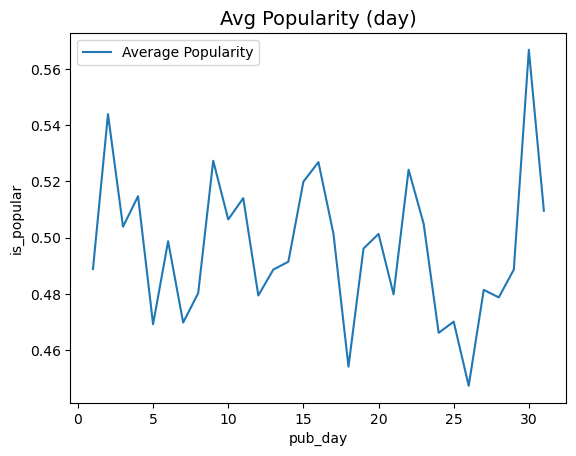

In [18]:
print(train.groupby('pub_day').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_day').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (day)', fontsize=14)
#train = train.drop(columns = ['pub_day'])
#train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
#print(train.corr()['is_popular']['is_noon'])

pub_month
1     0.536854
2     0.489640
3     0.468809
4     0.471976
5     0.456897
6     0.477487
7     0.505459
8     0.496158
9     0.493792
10    0.502518
11    0.519792
12    0.539916
Name: is_popular, dtype: float64


Text(0.5, 1.0, 'Avg Popularity (month)')

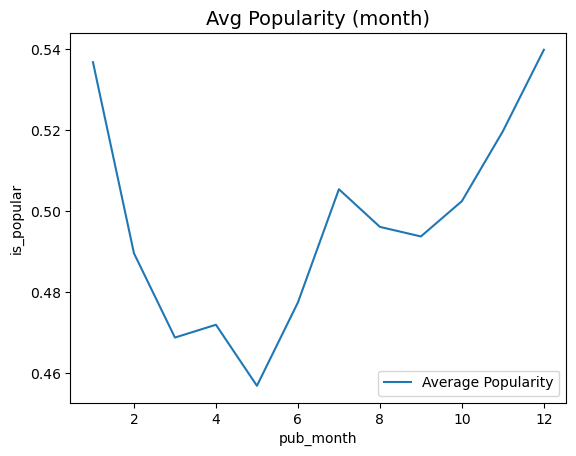

In [19]:
print(train.groupby('pub_month').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_month').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (month)', fontsize=14)
#train = train.drop(columns = ['pub_month'])
#train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
#print(train.corr()['is_popular']['is_noon'])

News desk	

In [27]:
train['group_by_news_desk'] = train['is_popular'].groupby(train['news_desk']).transform('mean')
#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular']['group_by_news_desk'])
train['feature_news_desk'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_news_desk'])

0.5433046797673902
0.5402178428262426


<font size=6>Section</font>

In [34]:
train['group_by_section_name'] = train['is_popular'].groupby(train['section_name']).transform('mean')
train = train.sort_values(['group_by_section_name'],ascending=False)
print(train.corr()['is_popular']['group_by_section_name'])
train['feature_section_name'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_section_name'])

0.5326935480413444
0.5402178428262414


<font size=6>Subsection</font>

In [37]:
train['group_by_section_name'] = train['is_popular'].groupby(train['section_name']).transform('mean')
train = train.sort_values(['group_by_section_name'],ascending=False)
print(train.corr()['is_popular']['group_by_section_name'])
train['feature_section_name'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_section_name'])

0.532693548041351
0.5402178428262444


<font size=6>Subsection</font>

In [36]:
train['group_by_subsection_name'] = train['is_popular'].groupby(train['subsection_name']).transform('mean')
train = train.sort_values(['group_by_subsection_name'],ascending=False)
print(train.corr()['is_popular']['group_by_subsection_name'])
train['feature_subsection_name'] = train['group_by_subsection_name'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_subsection_name'])

0.5601977859285814
0.5587763209685831


<font size=6>Material</font>

Index(['web_url', 'print_section', 'print_page', 'news_desk', 
        'word_count', 'subsection_name', 'pub_year',
       'pub_month', 'pub_day', 'pub_weekday', 'pub_time', 'abstract',
       'abstract_len', 'abstract_dup', 'headline', 'headline_len',
       'headline_dup', 'headline_kicker', 'len_lead', 'keywords', 'authors',
       'is_popular'],
      dtype='object')